In [159]:
import json
import os
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu, chi2_contingency, ttest_ind 
from scipy.stats import anderson, anderson_ksamp
from scipy.stats import chi2, t, sem
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time
import json
import random
import warnings
warnings.filterwarnings('ignore')
from dataclasses import asdict
from datetime import datetime, date
import io

all_data = pd.read_csv('/kaggle/input/shiftlogs/bureau.csv')

target = pd.read_csv('/kaggle/input/shiftlogs/application_train.csv')
target = target[['SK_ID_CURR', 'TARGET', 'AMT_INCOME_TOTAL', 'AMT_CREDIT']]

all_data = pd.merge(all_data, target, on="SK_ID_CURR", how="left")
all_data = all_data[all_data['TARGET'].notna()]
all_data = all_data.drop_duplicates(subset=['SK_ID_CURR'])
all_data

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.000,NaN,0.0,Consumer credit,-131,NaN,0.0,270000.0,720000.0
7,162297,5714469,Closed,currency 1,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.000,0.000,0.0,Consumer credit,-1710,NaN,0.0,171000.0,518562.0
13,402440,5714475,Active,currency 1,-96,0,269.0,NaN,0.0,0,89910.00,76905.000,0.000,0.0,Consumer credit,-22,NaN,0.0,67500.0,327024.0
14,238881,5714482,Closed,currency 1,-318,0,-187.0,-187.0,NaN,0,0.00,0.000,0.000,0.0,Credit card,-185,NaN,0.0,166500.0,558000.0
21,222183,5714491,Active,currency 1,-784,0,1008.0,NaN,0.0,0,0.00,-411.615,411.615,0.0,Credit card,-694,NaN,0.0,315000.0,592560.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1715434,207190,5052629,Closed,currency 1,-532,0,45.0,-227.0,NaN,0,450000.00,0.000,0.000,0.0,Consumer credit,-31,NaN,0.0,225000.0,900000.0
1715484,324956,5054382,Closed,currency 1,-381,0,-199.0,-199.0,0.0,0,19800.00,0.000,0.000,0.0,Consumer credit,-199,0.0,0.0,31500.0,269550.0
1715600,448157,5043236,Active,currency 1,-1441,0,2197.0,NaN,NaN,0,1800000.00,1076809.500,0.000,0.0,Mortgage,-2,NaN,0.0,270000.0,755190.0
1715863,345866,5053303,Closed,currency 1,-375,0,-41.0,-19.0,NaN,0,175054.50,NaN,NaN,0.0,Consumer credit,-4,17140.5,0.0,67500.0,835380.0


Что сделать?
Написать скрипт(ы) по проверке признаков (любым из способов, озвученных на лекции, можно использовать комбинации, можно дополнить чем-то своим) по различным датасетам из конкурса. Один датасет - один скрипт:
a. POS_CASH_balance.csv - по желание если останется время
b. application_test.csv
c. application_train.csv
d. bureau.csv
e. bureau_balance.csv
f. credit_card_balance.csv
g. installments_payments.csv
h. previous_application.csv
Общие требования (упорядочены в порядки убывания важности):
a. Скрипт загружен в GitLab, сделан МР с изменениями, предоставлена ссылка на МР
b. Код является воспроизводимым
c. Результатом работы каждого скрипта является csv файл со значимыми признаками.
d. Приемлемое время выполнения скрипта.
e. Скрипт содержит функцию main(), при вызове которой выполняется загрузка уже насчитанных признаков и проверка признаков. При этом, должна быть реализована возможность задания следующих параметров:
i. Путь к входному файлу
ii. Путь к результирующему .csv файлу
f. Структура и качество кода:
i. Выделение отдельных логических частей в виде функций
ii. Вынесение общей логики в отдельные функции с целью переиспользования
iii. Документирование кода
iv. Осмысленные имена переменных

In [160]:
#  экономим время
all_data = all_data.head(100)
all_data = all_data._get_numeric_data()
all_data = all_data.fillna(0)
# all_data = all_data[['SK_ID_CURR', 'TARGET', 'CNT_CHILDREN', 'AMT_INCOME_TOTAL']]
all_data

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT
0,215354,5714462,-497,0,-153.0,-153.0,0.0,0,91323.00,0.000,0.000,0.0,-131,0.0,0.0,270000.0,720000.0
7,162297,5714469,-1896,0,-1684.0,-1710.0,14985.0,0,76878.45,0.000,0.000,0.0,-1710,0.0,0.0,171000.0,518562.0
13,402440,5714475,-96,0,269.0,0.0,0.0,0,89910.00,76905.000,0.000,0.0,-22,0.0,0.0,67500.0,327024.0
14,238881,5714482,-318,0,-187.0,-187.0,0.0,0,0.00,0.000,0.000,0.0,-185,0.0,0.0,166500.0,558000.0
21,222183,5714491,-784,0,1008.0,0.0,0.0,0,0.00,-411.615,411.615,0.0,-694,0.0,0.0,315000.0,592560.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
500,142568,5715115,-50,0,0.0,0.0,0.0,0,22500.00,0.000,0.000,0.0,-45,0.0,0.0,225000.0,1067418.0
503,356727,5715121,-2135,0,-1953.0,-1932.0,0.0,0,45616.50,0.000,0.000,0.0,-1929,0.0,0.0,135000.0,269550.0
511,250551,5715131,-955,0,-650.0,-650.0,0.0,0,176625.00,0.000,0.000,0.0,-640,0.0,0.0,81000.0,292500.0
514,224915,5715135,-1249,0,-882.0,-882.0,0.0,0,143910.00,0.000,0.000,0.0,-870,0.0,0.0,180000.0,1082214.0


In [161]:
np.random.choice(all_data['AMT_INCOME_TOTAL'], size=all_data.shape[0], replace=True)

array([135000., 405000., 112500.,  67500., 135000., 157500., 112500.,
       247500.,  67500., 202500., 270000., 148500.,  90000., 180000.,
       157500., 225000.,  67500., 135000., 180000., 112500., 112500.,
       157500., 270000., 202500., 162000., 135000.,  76500.,  76500.,
       157500., 180000., 247500., 135000., 130500., 135000., 126000.,
       225000.,  67500.,  67500.,  81000., 202500., 225000., 157500.,
       148500., 157500., 202500.,  90000., 180000.,  76500., 157500.,
       112500., 135000., 135000., 135000.,  85500., 112500., 189000.,
       180000., 180000.,  90000., 130500., 225000., 166500., 171000.,
       180000., 225000., 157500., 315000., 180000., 102600., 112500.,
       180000., 112500.,  90000., 225000., 270000., 225000., 175500.,
        90000., 225000., 135000., 102600., 180000., 270000., 180000.,
        85500.,  76500., 270000., 202500., 108000.,  67500., 112500.,
        67500.,  90000.,  67500., 171000., 180000., 135000., 166500.,
       135000.,  765

(array([18., 13., 23., 19., 16.,  0.,  5.,  4.,  1.,  1.]),
 array([ 61650.,  95985., 130320., 164655., 198990., 233325., 267660.,
        301995., 336330., 370665., 405000.]),
 <BarContainer object of 10 artists>)

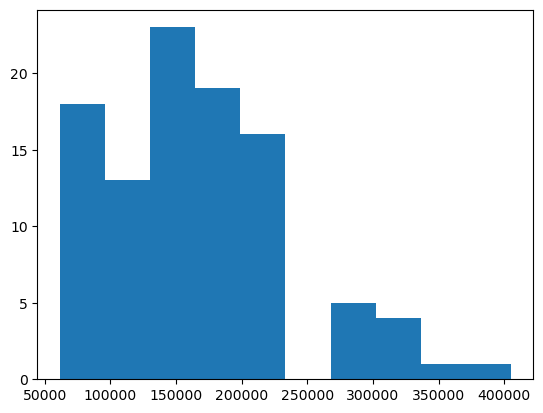

In [162]:
plt.hist(np.random.choice(all_data['AMT_INCOME_TOTAL'], size=all_data.shape[0], replace=True))

(array([16., 13., 25., 17., 15.,  1.,  4.,  3.,  3.,  3.]),
 array([ 58500.,  93150., 127800., 162450., 197100., 231750., 266400.,
        301050., 335700., 370350., 405000.]),
 <BarContainer object of 10 artists>)

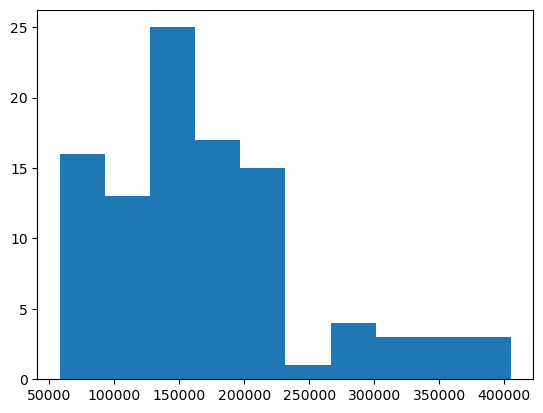

In [163]:
plt.hist(np.random.choice(all_data['AMT_INCOME_TOTAL'], size=all_data.shape[0], replace=True))

In [164]:
n = 10000
mean_dist = []
for i in tqdm(range(n)):
    itersample = np.random.choice(all_data[(all_data['TARGET']==1)]['AMT_CREDIT'], size=all_data[(all_data['TARGET']==1)].shape[0], replace=True)
    mean_dist.append(np.mean(itersample))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [165]:
mean_dist_s = []
for i in tqdm(range(n)):
    itersample = all_data[(all_data['TARGET']==1)]['AMT_CREDIT'].sample(
        all_data[(all_data['TARGET']==1)].shape[0],
        replace = True # параметр возвращения
    ).values
    mean_dist_s.append(np.mean(itersample))

  0%|          | 0/10000 [00:00<?, ?it/s]

In [166]:
p = 0.95
pd.Series(mean_dist).quantile([(1 + p) / 2, 1 - (1 + p) / 2])

0.975    696470.775
0.025    446614.200
dtype: float64

In [167]:
def confidence_interval(
    s1, s2, n, p
):
    '''
    Вычисление доверительного интервала
    
    s1 - распределение средних для 1 группы
    s2 - распределение средних для 2 группы
    n - объем смоделируемой выборки
    p = 1-alpha - 95% 
    
    return:
    (s1[l_indx], s1[u_indx]), (s2[l_indx], s2[u_indx]) - доверительные интервалы для 2х групп
    '''
    u_pval = (1 + p) / 2
    l_pval = (1 - u_pval)
    l_indx = int(np.floor(n*l_pval))
    u_indx = int(np.floor(n*u_pval))
    return (s1[l_indx], s1[u_indx]), (s2[l_indx], s2[u_indx])

In [168]:
def bootstrap(
    data1, 
    data2, 
    n=10000, 
    func=np.mean, 
    subtr=np.subtract, 
    alpha=0.05
):
    '''
    Бутстрап средних значений для двух групп
    
    data1 - выборка 1 группы
    data2 - выборка 2 группы
    n=10000 - сколько раз моделировать
    func=np.mean - функция отвыборки, например, среднее
    subtr=np.subtract, 
    alpha=0.05 - 95% доверительный интервал
    
    return:
    ci_diff - доверительный интервал разницы средних для двух групп
    s1 - распределение средних для 1 группы
    s2 - распределение средних для 2 группы
    confidence_interval(s1, s2, n, 1 - alpha) - доверительные интервалы для двух групп
    '''
    s1, s2 = [], []
    s1_size = len(data1)
    s2_size = len(data2)
    
    
    for i in tqdm(range(n)):
        itersample1 = np.random.choice(data1, size=s1_size, replace=True)
        s1.append(func(itersample1))
        itersample2 = np.random.choice(data2, size=s2_size, replace=True)
        s2.append(func(itersample2))
    s1.sort()
    s2.sort()
    
    #доверительный интервал разницы
    bootdiff = subtr(s2, s1)
    bootdiff.sort()

    ci_diff = (np.round(bootdiff[np.round(n*alpha/2).astype(int)], 3), 
               np.round(bootdiff[np.round(n*(1-alpha/2)).astype(int)], 3))  
    
    return ci_diff, s1, s2, confidence_interval(s1, s2, n, 1 - alpha)

In [169]:
def plot_bootstraping_mean(
    data, 
    y, 
    feat_name=None,
    val=[0, 1]
):
    '''
    Бутстрап средних значений для любого признака
    
    data - датафрейм с данными
    y - таргет
    feat_name - название признака, строка
    
    return:
    cidiff - доверительный интервал разницы в средних значениях для двух групп
    '''
    data1 = data[(y==val[0])][feat_name]
    data2 = data[(y==val[1])][feat_name]
    s1_mean_init = np.mean(data1)
    s2_mean_init = np.mean(data2)
      
    cidiff, s1, s2, ci = bootstrap(data1, data2)
    
    plt.hist(x=s1, density='uniform',  label=f'target={val[0]}', bins='auto', alpha=0.8, color='darkorange' )
    plt.hist(x=s2, density='uniform', label=f'target={val[1]}', bins='auto', alpha=0.6, color='royalblue')
    plt.legend()
    plt.axvline(x=s1_mean_init, color='darkorange')
    plt.axvline(x=s2_mean_init, color='royalblue')
    plt.axvline(x=ci[0][0], color='orange', linestyle='--')
    plt.axvline(x=ci[0][1], color='orange', linestyle='--')
    plt.axvline(x=ci[1][0], color='blue', linestyle='--')
    plt.axvline(x=ci[1][1], color='blue', linestyle='--')
    plt.show()
    
    return cidiff

In [170]:
def verdict(ci_diff):
    cidiff_min=0.001 #,близкое к 0
    ci_diff_abs = [abs(ele) for ele in ci_diff]
    if (min(ci_diff) <= cidiff_min <= max(ci_diff)):
        print(ci_diff,'Различия в средних статистически незначимы.')
    elif (cidiff_min >= max(ci_diff_abs) >= 0) or (cidiff_min >= min(ci_diff_abs) >= 0):
        print(ci_diff,'Различия в средних статистически незначимы.')
    else:
        print(ci_diff,'Различия в средних статистически значимы.')
        return 1

In [171]:
all_data['AMT_CREDIT'] = all_data.AMT_INCOME_TOTAL.fillna(0)

  0%|          | 0/10000 [00:00<?, ?it/s]

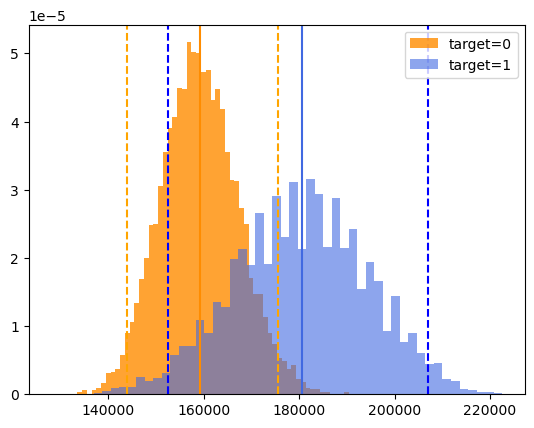

In [172]:
cidiff = plot_bootstraping_mean(all_data, all_data['TARGET'],  feat_name='AMT_CREDIT')


In [173]:
verdict(cidiff)

(8688.703, 31410.802) Различия в средних статистически значимы.


1

In [174]:
def main(df):
    important_features = pd.DataFrame()
    list_columns = df.columns
    
    for i in list_columns:
        cidiff = plot_bootstraping_mean(df, df['TARGET'],  feat_name=i)
        verdict(cidiff)
        if verdict(cidiff) == 1:
            important_features[i] = df[i]
            print('find important feature')
    display(important_features)
    important_features.to_csv('important_features.csv')
        

  0%|          | 0/10000 [00:00<?, ?it/s]

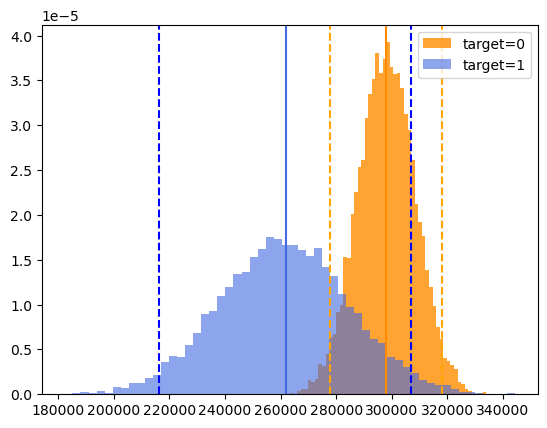

(-61548.636, -11322.545) Различия в средних статистически значимы.
(-61548.636, -11322.545) Различия в средних статистически значимы.
find important feature


  0%|          | 0/10000 [00:00<?, ?it/s]

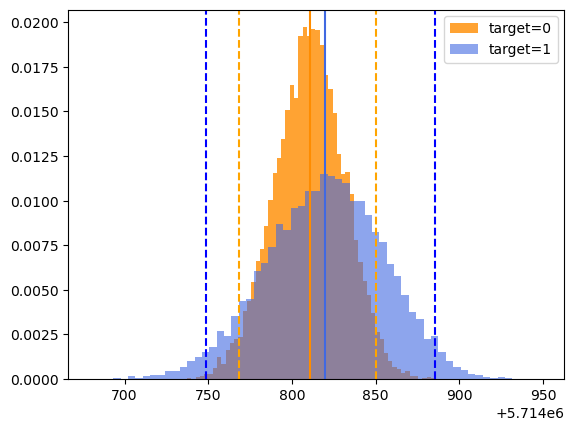

(-19.534, 35.526) Различия в средних статистически незначимы.
(-19.534, 35.526) Различия в средних статистически незначимы.


  0%|          | 0/10000 [00:00<?, ?it/s]

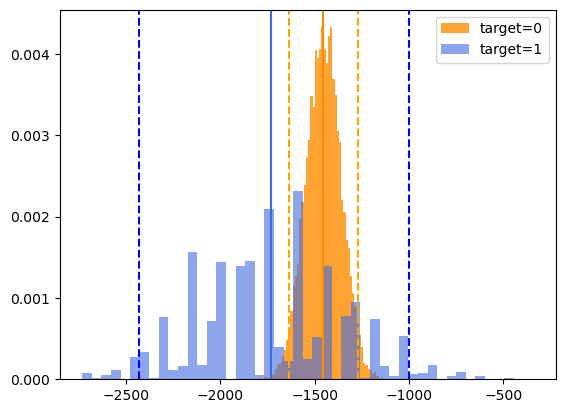

(-796.426, 273.805) Различия в средних статистически незначимы.
(-796.426, 273.805) Различия в средних статистически незначимы.


  0%|          | 0/10000 [00:00<?, ?it/s]

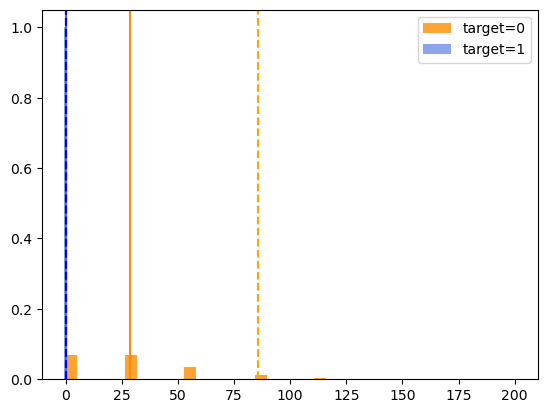

(-85.813, 0.0) Различия в средних статистически незначимы.
(-85.813, 0.0) Различия в средних статистически незначимы.


  0%|          | 0/10000 [00:00<?, ?it/s]

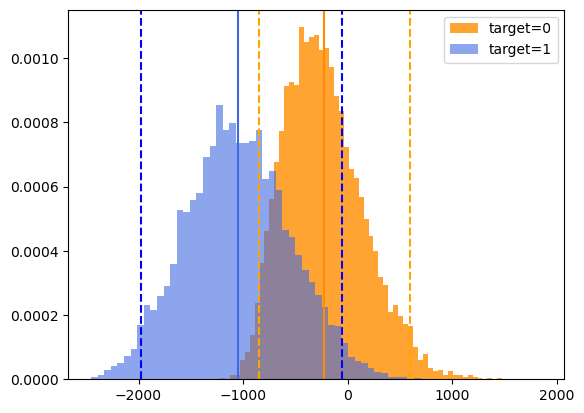

(-1127.385, -659.883) Различия в средних статистически значимы.
(-1127.385, -659.883) Различия в средних статистически значимы.
find important feature


  0%|          | 0/10000 [00:00<?, ?it/s]

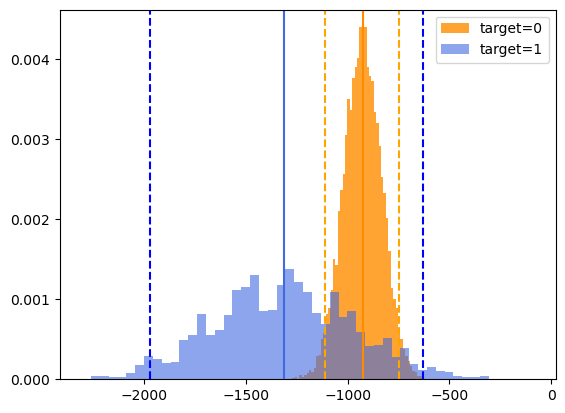

(-862.255, 117.25) Различия в средних статистически незначимы.
(-862.255, 117.25) Различия в средних статистически незначимы.


  0%|          | 0/10000 [00:00<?, ?it/s]

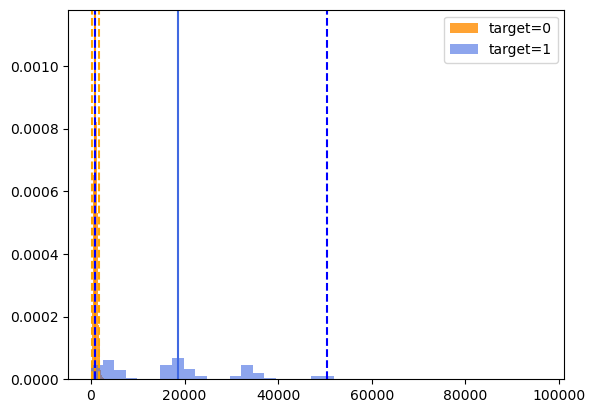

(537.14, 48555.679) Различия в средних статистически значимы.
(537.14, 48555.679) Различия в средних статистически значимы.
find important feature


  0%|          | 0/10000 [00:00<?, ?it/s]

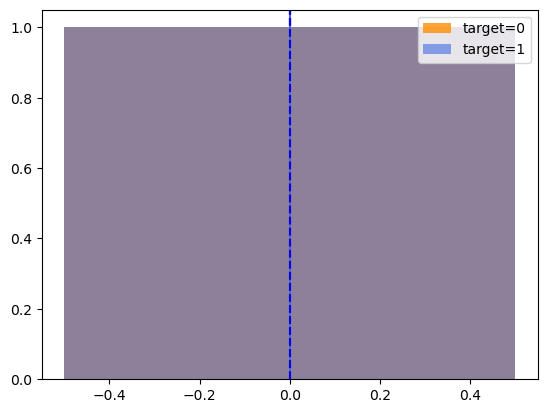

(0.0, 0.0) Различия в средних статистически незначимы.
(0.0, 0.0) Различия в средних статистически незначимы.


  0%|          | 0/10000 [00:00<?, ?it/s]

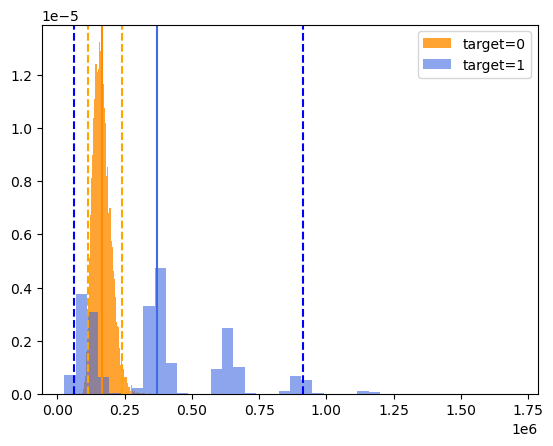

(-53976.244, 674887.628) Различия в средних статистически незначимы.
(-53976.244, 674887.628) Различия в средних статистически незначимы.


  0%|          | 0/10000 [00:00<?, ?it/s]

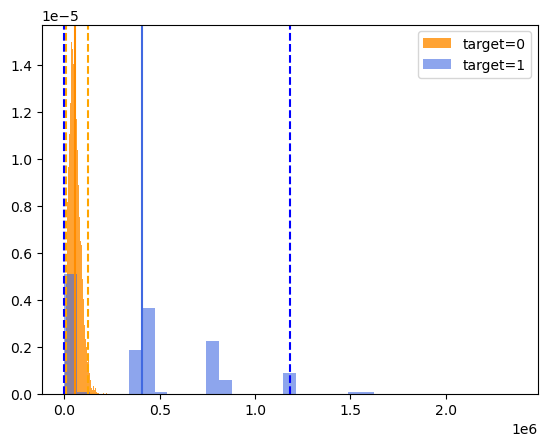

(-18716.992, 1070351.475) Различия в средних статистически незначимы.
(-18716.992, 1070351.475) Различия в средних статистически незначимы.


  0%|          | 0/10000 [00:00<?, ?it/s]

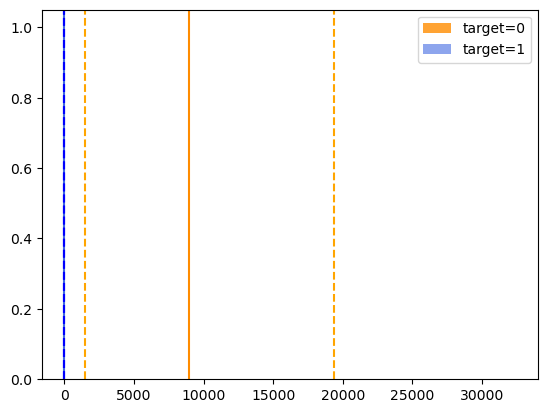

(-19345.056, -1496.392) Различия в средних статистически значимы.
(-19345.056, -1496.392) Различия в средних статистически значимы.
find important feature


  0%|          | 0/10000 [00:00<?, ?it/s]

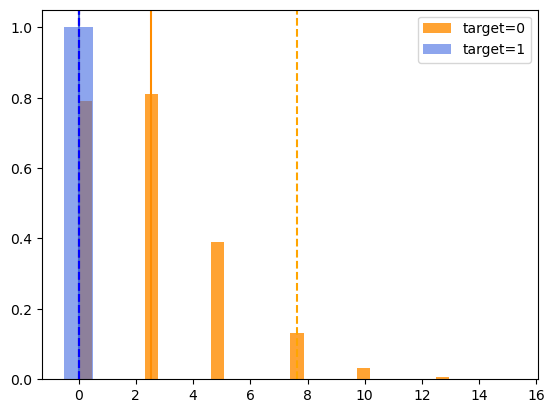

(-7.633, 0.0) Различия в средних статистически незначимы.
(-7.633, 0.0) Различия в средних статистически незначимы.


  0%|          | 0/10000 [00:00<?, ?it/s]

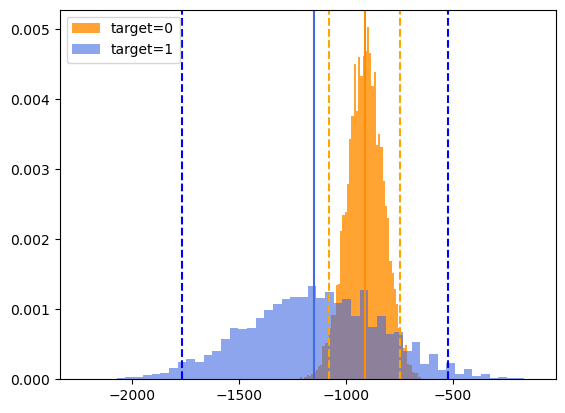

(-687.537, 222.698) Различия в средних статистически незначимы.
(-687.537, 222.698) Различия в средних статистически незначимы.


  0%|          | 0/10000 [00:00<?, ?it/s]

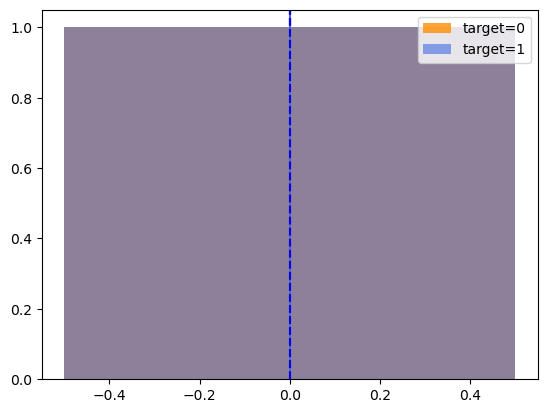

(0.0, 0.0) Различия в средних статистически незначимы.
(0.0, 0.0) Различия в средних статистически незначимы.


  0%|          | 0/10000 [00:00<?, ?it/s]

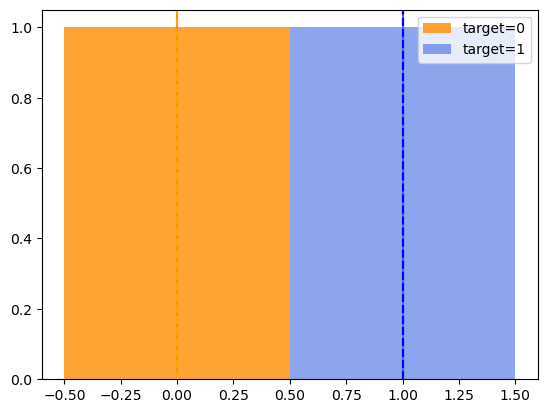

(1.0, 1.0) Различия в средних статистически значимы.
(1.0, 1.0) Различия в средних статистически значимы.
find important feature


  0%|          | 0/10000 [00:00<?, ?it/s]

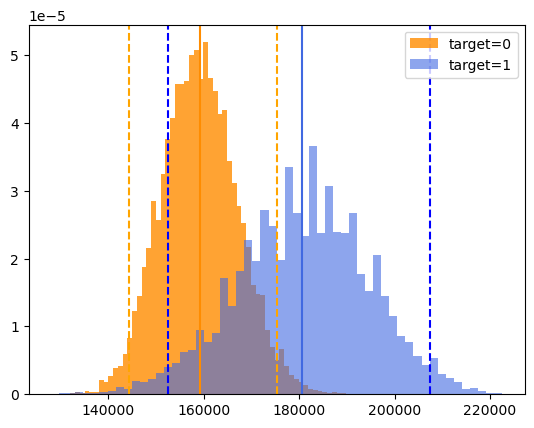

(8293.099, 31977.593) Различия в средних статистически значимы.
(8293.099, 31977.593) Различия в средних статистически значимы.
find important feature


  0%|          | 0/10000 [00:00<?, ?it/s]

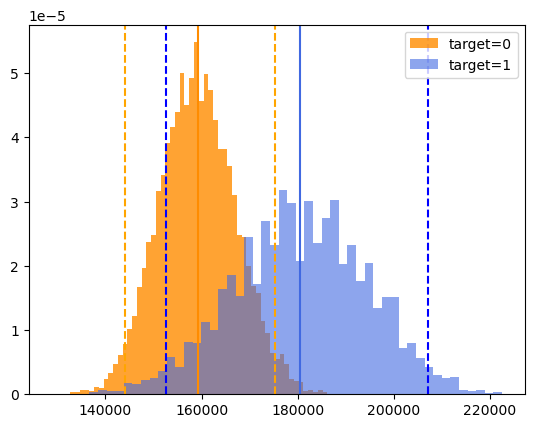

(8465.385, 31538.462) Различия в средних статистически значимы.
(8465.385, 31538.462) Различия в средних статистически значимы.
find important feature


,SK_ID_CURR,DAYS_CREDIT_ENDDATE,AMT_CREDIT_MAX_OVERDUE,AMT_CREDIT_SUM_LIMIT,TARGET,AMT_INCOME_TOTAL,AMT_CREDIT
0,215354,-153.0,0.0,0.000,0.0,270000.0,270000.0
7,162297,-1684.0,14985.0,0.000,0.0,171000.0,171000.0
13,402440,269.0,0.0,0.000,0.0,67500.0,67500.0
14,238881,-187.0,0.0,0.000,0.0,166500.0,166500.0
21,222183,1008.0,0.0,411.615,0.0,315000.0,315000.0
...,...,...,...,...,...,...,...
500,142568,0.0,0.0,0.000,0.0,225000.0,225000.0
503,356727,-1953.0,0.0,0.000,0.0,135000.0,135000.0
511,250551,-650.0,0.0,0.000,0.0,81000.0,81000.0
514,224915,-882.0,0.0,0.000,0.0,180000.0,180000.0


In [175]:
main(all_data)